In [820]:
# For Analysis
import numpy as np
import pandas as pd

# For Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# For Calculations
from math import floor

#For Modeling
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

## Importing and looking at the Data

Reading in the datasets

In [821]:
listings = pd.read_csv('../data/airbnb_listings.csv')
stations = pd.read_csv('../data/train_stations.csv')
neighbourhoods = pd.read_csv('../data/neighbourhood_score.csv')
attractions = pd.read_csv('../data/attractions.csv')

In [822]:
listings.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,Neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [823]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
id                        74111 non-null int64
log_price                 74111 non-null float64
property_type             74111 non-null object
room_type                 74111 non-null object
amenities                 74111 non-null object
accommodates              74111 non-null int64
bathrooms                 73911 non-null float64
bed_type                  74111 non-null object
cancellation_policy       74111 non-null object
cleaning_fee              74111 non-null bool
city                      74111 non-null object
description               74111 non-null object
first_review              58247 non-null object
host_has_profile_pic      73923 non-null object
host_identity_verified    73923 non-null object
host_response_rate        55812 non-null object
host_since                73923 non-null object
instant_bookable          74111 non-null object
last_review               582

There were no detailed descriptions given along with the dataset other than for id and log_price. Thus we need to do some EDA to identify the different features.
 We observe that, the following columns need to be changed to the correect data type.
- id to string
- first_review, host_since, last_review to date.
- instant_bookable, host_identity_verified, host_has_profie_pictore to Number encoded values.
- host_response_rate to a numerical column.

Some of the things to check
- Distributions of the variables
- Whether there are duplicates in the zip code
- Clusters in the data
- There are some facilities with the same names and same descriptions. 


In [824]:
# Check the statistical distribution for Numerical Columns
listings.describe()

,id,log_price,accommodates,bathrooms,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
count,7.411100e+04,74111.000000,74111.000000,73911.000000,74111.000000,74111.000000,74111.000000,57389.000000,74020.000000,73980.000000
mean,1.126662e+07,4.782069,3.155146,1.235263,38.445958,-92.397525,20.900568,94.067365,1.265793,1.710868
std,6.081735e+06,0.717394,2.153589,0.582044,3.080167,21.705322,37.828641,7.836556,0.852143,1.254142
min,3.440000e+02,0.000000,1.000000,0.000000,33.338905,-122.511500,0.000000,20.000000,0.000000,0.000000
25%,6.261964e+06,4.317488,2.000000,1.000000,34.127908,-118.342374,1.000000,92.000000,1.000000,1.000000
50%,1.225415e+07,4.709530,2.000000,1.000000,40.662138,-76.996965,6.000000,96.000000,1.000000,1.000000
75%,1.640226e+07,5.220356,4.000000,1.000000,40.746096,-73.954660,23.000000,100.000000,1.000000,2.000000
max,2.123090e+07,7.600402,16.000000,8.000000,42.390437,-70.985047,605.000000,100.000000,10.000000,18.000000


In [825]:
# Check the distribution of Categorical and Text columns
listings.describe(include = ["O"])

,property_type,room_type,amenities,bed_type,cancellation_policy,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,name,Neighbourhood,thumbnail_url,zipcode
count,74111,74111,74111,74111,74111,74111,74111,58247,73923,73923,55812,73923,74111,58284,74111,74111,65895,73529
unique,35,3,67122,5,5,6,73472,2554,2,2,80,3087,2,1371,73350,1722,65883,673
top,Apartment,Entire home/apt,{},Real Bed,strict,NYC,"Hello, I've been running guest house for Korea...",1/1/2017,t,t,100%,3/30/2015,f,4/30/2017,#NAME?,Williamsburg,https://a0.muscache.com/im/pictures/70087089/b...,11211
freq,49003,41310,586,72028,32374,32349,8,293,73697,49748,43254,246,54660,1344,10,2862,3,1618


In [826]:
listings.columns

Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'description', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'latitude',
       'longitude', 'name', 'Neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'thumbnail_url', 'zipcode', 'bedrooms', 'beds'],
      dtype='object')

In [827]:
lower_dim_categories = ['property_type', 'room_type', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable']
[listings[c].value_counts() for c in lower_dim_categories]

[Apartment             49003
 House                 16511
 Condominium            2658
 Townhouse              1692
 Loft                   1244
 Other                   607
 Guesthouse              498
 Bed & Breakfast         462
 Bungalow                366
 Villa                   179
 Dorm                    142
 Guest suite             123
 Camper/RV                94
 Timeshare                77
 Cabin                    72
 In-law                   71
 Hostel                   70
 Boutique hotel           69
 Boat                     65
 Serviced apartment       21
 Tent                     18
 Castle                   13
 Vacation home            11
 Yurt                      9
 Hut                       8
 Treehouse                 7
 Chalet                    6
 Earth House               4
 Tipi                      3
 Cave                      2
 Train                     2
 Island                    1
 Parking Space             1
 Casa particular           1
 Lighthouse   

In [828]:
def pp_fix_dtypes(df):
    #Correct the types of the data where required
    df = df.assign(
        id = df.id.astype(str),
        first_review = pd.to_datetime(df.first_review),
        last_review = pd.to_datetime(df.last_review),
        host_since = pd.to_datetime(df.host_since)
    )
    return df
    

In [829]:
listings = pp_fix_dtypes(listings)

### Functions for handling Missing Values

In [830]:
def get_max_date(df):
    most_recent_date = max(
            max(df.host_since),
            max(df.first_review),
            max(df.last_review)
        )
    return most_recent_date

In [831]:
most_recent_date = get_max_date(listings)

In [832]:
listings.isnull().sum().sort_values(ascending = False)

host_response_rate        18299
review_scores_rating      16722
first_review              15864
last_review               15827
thumbnail_url              8216
zipcode                     582
bathrooms                   200
host_identity_verified      188
host_has_profile_pic        188
host_since                  188
beds                        131
bedrooms                     91
instant_bookable              0
bed_type                      0
log_price                     0
property_type                 0
room_type                     0
amenities                     0
accommodates                  0
number_of_reviews             0
cancellation_policy           0
latitude                      0
cleaning_fee                  0
city                          0
description                   0
Neighbourhood                 0
name                          0
longitude                     0
id                            0
dtype: int64

In [833]:
listings[['host_since','first_review','last_review']].describe()

,host_since,first_review,last_review
count,73923,58247,58284
unique,3087,2554,1371
top,2015-03-30 00:00:00,2017-01-01 00:00:00,2017-04-30 00:00:00
freq,246,293,1344
first,2008-03-03 00:00:00,2008-11-17 00:00:00,2009-01-21 00:00:00
last,2017-10-04 00:00:00,2017-10-05 00:00:00,2017-10-05 00:00:00


**Notes for handling Missing Values**

host_since:
- Take the date of first_review where avilable.
- In some records, the date of first review is before the host_date. It is possible that 
    - the listing was changed at a later date - Update first_review date to host_date
    - the dates were read in the wrong order - Swap the first_review_date and host_date

In [834]:
def handle_missing(df):
    temp_df = df.copy()
    
    # Fill the Host Since column with the date of first review if available
    temp_df.host_since = df.host_since.fillna(df.first_review)
    
    # Fill the Thumbnails Column and recode it 
    temp_df.thumbnail_url.fillna(0, inplace=True)
    temp_df.loc[temp_df.thumbnail_url != 0, ['thumbnail_url']] = 1
    
    # Fill missing values for some columns with 0
    temp_df.bedrooms.fillna(0, inplace = True)
    temp_df.bathrooms.fillna(0, inplace = True)
    temp_df.beds.fillna(0, inplace = True)
    
    # Drop the rows with missing values for particular  columns
    temp_df.dropna(subset = ['host_since','host_has_profile_pic'], inplace = True)
    
    # Drop the columns that have a lot of missing values and are not useful for analysis
    #temp_df.drop(['first_review','last_review','zipcode'], axis = 1, inplace = True)
    
    return temp_df

In [835]:
listings = handle_missing(listings)
listings.isnull().sum().sort_values(ascending = False)

host_response_rate        18111
review_scores_rating      16675
first_review              15822
last_review               15791
zipcode                     580
city                          0
cleaning_fee                  0
cancellation_policy           0
bed_type                      0
beds                          0
bathrooms                     0
description                   0
amenities                     0
room_type                     0
property_type                 0
log_price                     0
accommodates                  0
host_identity_verified        0
host_has_profile_pic          0
bedrooms                      0
host_since                    0
instant_bookable              0
latitude                      0
longitude                     0
name                          0
Neighbourhood                 0
number_of_reviews             0
thumbnail_url                 0
id                            0
dtype: int64

### Data Preprocessing

**Function for calculating distance to attractions**

We have the attractions.csv file that contains the lat long of top 3 attractions in each of the 6 states. We us this to calculate the distance from the listing to each of those locations.

In [839]:
#https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas
def haversine_np(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6372.8 * c
    return km

In [840]:
# Check the structure of the attractions data
attractions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 10 columns):
city                6 non-null object
attraction1         6 non-null object
attraction1_lat     6 non-null float64
attraction1_long    6 non-null float64
attraction2         6 non-null object
attraction2_lat     6 non-null float64
attraction2_long    6 non-null float64
attraction3         6 non-null object
attraction3_lat     6 non-null float64
attraction3_long    6 non-null float64
dtypes: float64(6), object(4)
memory usage: 560.0+ bytes


**Function to calculate distance to attractions given the LatLong**

In [841]:
def calc_dist_to_attractions(df):
    df = pd.merge(df,attractions, on='city', how="left", indicator=False)
    df = df.assign(
        dist_to_attr1 = haversine_np(df["attraction1_lat"],df["attraction1_long"],df["latitude"],df["longitude"]),
        dist_to_attr2 = haversine_np(df["attraction2_lat"],df["attraction2_long"],df["latitude"],df["longitude"]),
        dist_to_attr3 = haversine_np(df["attraction3_lat"],df["attraction3_long"],df["latitude"],df["longitude"])
    )
    df.drop(["attraction1","attraction2","attraction3", "attraction1_lat","attraction1_long","attraction2_lat","attraction2_long","attraction3_lat","attraction3_long" ],axis = 1,inplace = True) 
    return df
             
listings = calc_dist_to_attractions(listings)   
    
listings.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,Neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds,dist_to_attr1,dist_to_attr2,dist_to_attr3
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,Brooklyn Heights,2,100.0,1,11201,1.0,1.0,4.533604,9.858104,6.974862
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,Hell's Kitchen,6,93.0,1,10019,3.0,3.0,9.748908,2.729491,0.878994
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,Harlem,10,92.0,1,10027,1.0,3.0,15.715851,3.344257,6.450707
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,Lower Haight,0,NaN,1,94117,2.0,2.0,6.724060,6.163671,4.509624
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,Columbia Heights,4,40.0,0,20009,0.0,1.0,3.110579,4.260263,4.061666


**Function to calculate distance to closest railway station given the LatLong**

In [842]:
def calc_dist_to_closest_station(df):
    
    # Rename Columns in the stations dataset
    stations.columns = ['city', 'station_name', 'station_lat', 'station_long']
    
    # join with selected columns from the listings dataset
    df1 = df[['id','city','latitude','longitude']].merge(stations, on='city', how="inner", indicator=False)
    
    # Calculate the distance and save to a new column
    df1 = df1.assign(
        dist_to_station = haversine_np(df1["station_lat"],df1["station_long"],df1["latitude"],df1["longitude"])
    )
    
    
    df2 = df1.sort_values(['id', 'dist_to_station']).drop_duplicates(['id'])
    df1 = df.merge(df2[['id','dist_to_station']], on ="id", how = "inner", indicator = False)
    return df1
             
temp = calc_dist_to_closest_station(listings)   
    
temp.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds,dist_to_attr1,dist_to_attr2,dist_to_attr3,dist_to_station
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,2,100.0,1,11201,1.0,1.0,4.533604,9.858104,6.974862,0.162282
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,6,93.0,1,10019,3.0,3.0,9.748908,2.729491,0.878994,0.481606
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,10,92.0,1,10027,1.0,3.0,15.715851,3.344257,6.450707,0.151675
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,0,NaN,1,94117,2.0,2.0,6.724060,6.163671,4.509624,1.302130
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,4,40.0,0,20009,0.0,1.0,3.110579,4.260263,4.061666,0.373534


**Function to preprocess the features**

In [843]:
# Controls for the below function
recode_features = True
create_dummies = True

In [844]:
# Function to Preprocess the Data
def preprocess(df, test_data = False):
    
    global recode_features, create_dummies, most_recent_date
    
    temp_df = df.copy()
    #Recode features where required
    if recode_features == True:
        temp_df = temp_df.replace(
            {
            'host_has_profile_pic': {'t': True, 'f': False},
            'host_identity_verified': {'t': True, 'f': False},
            'instant_bookable': {'t': True, 'f': False},
            'cancellation_policy': {'super_strict_30':'strict','super_strict_60':'strict'}
            }
        )
        recode_features = False
    
    # Create Dummies and Drop the original columns
    ## For room_type and city. 
    if create_dummies == True:
        temp_df = pd.concat([temp_df, pd.get_dummies(temp_df['room_type'])], axis=1)
        temp_df = pd.concat([temp_df, pd.get_dummies(temp_df['city'])], axis=1)
        create_dummies = False
    
    #Convert date fields into days_since and useful components
    ## Calculate the Maximum Date Present in the Data
    if test_data == False:
        most_recent_date = get_max_date(temp_df)
    print("Reference Date Used: ", most_recent_date)
    
    
    ## Derive the new columns
    temp_df = temp_df.assign(
        year_of_listing = temp_df.host_since.dt.year,
        month_of_listing = temp_df.host_since.dt.month,
        days_since_hosted = (most_recent_date - temp_df.host_since)/np.timedelta64(1, 'D')
        #days_since_first_review = (most_recent_date - temp_df.first_review)/np.timedelta64(1, 'D'),
        #days_since_last_review = (most_recent_date - temp_df.last_review)/np.timedelta64(1, 'D')
    )
    
    # Calculate the bedroom and bathroom share per person. Higher the share, more the comfort.
    temp_df = temp_df.assign(
        bedroom_share = temp_df.bedrooms/temp_df.accommodates,
        bathroom_share = temp_df.bathrooms/temp_df.accommodates
    )
    
    # Drop the Features that are not needed
    temp_df.drop(['beds', 'bedrooms', 'bathrooms', 'room_type', 
                  'city', 'first_review','last_review','zipcode' ], axis = 1, inplace = True)
    
    df = temp_df
    print("Preprocessing Completed")
    
    return df

In [845]:
# Preprocess the Listings data
listings = preprocess(listings)

Reference Date Used:  2017-10-05 00:00:00
Preprocessing Completed


#### Add in Columns from Topic Modeling

In [846]:
# Read in the data
description_data = pd.read_csv("../data/airbnb_listings_LDA.csv")

In [847]:
# Check the column names
description_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 8 columns):
id                     74111 non-null int64
description            74111 non-null object
Description_Length     74111 non-null float64
Sentiment_intensity    74111 non-null float64
LDA_attractions        74111 non-null float64
LDA_transport          74111 non-null float64
LDA_amenities          74111 non-null float64
LDA_property_desc      74111 non-null float64
dtypes: float64(6), int64(1), object(1)
memory usage: 4.5+ MB


In [848]:
# Rename Columns to standard format
description_data.columns = ['id', 'description', 'description_length', 
                            'sentiment_intensity', 'lda_attractions', 
                            'lda_transport', 'lda_amenities', 'lda_property_desc']

# Change data type of id column
description_data.id = description_data.id.astype(str)

# Drop the description column to avoid duplicates
description_data.drop('description', axis = 1, inplace = True)

# Join the Data from Descriptions to the listings data
listings = listings.merge(description_data, how = "inner", on = 'id')

# Drop the description column in listings data as that is no longer required
listings.drop('description', axis = 1, inplace = True)


#### Pre-Processing AMENITIES

In [849]:
#Blank missing values in Amenities column
listings.loc[listings['amenities'] == '{}','amenities'] = ""

#Remove the symbols and one hot encode the amenities feature
listings['amenities'] = listings['amenities'].map(
    lambda amns: "|".join([amn.replace("}", "").replace("{", "").replace('"', "")\
                           for amn in amns.split(",")]))
amenities = np.unique(np.concatenate(listings['amenities'].map(lambda amns: amns.split("|")).values))
amenities_matrix = np.array([listings['amenities'].map(lambda amns: amn in amns).values for amn in amenities])
amen=pd.DataFrame(data=amenities_matrix.T, columns=amenities)

In [850]:
#Find important features from the amenities for target price prediction
listings_amenities = pd.concat([amen,listings['log_price'].reset_index()], axis=1)

#Remove junk amenities from the created features
listings_amenities=listings_amenities.drop(columns=['index','','translation missing: en.hosting_amenity_49','translation missing: en.hosting_amenity_50'])

#Reset and set numpy random seed for generating random numbers
np.random.seed(2018)
train = np.random.choice([True, False], listings_amenities.shape[0], replace=True, p=[0.8, 0.2])

#Using the random generated TRUE FALSE vector, perform the test train split
listings_amenities_train = listings_amenities.iloc[train,:].values
listings_amenities_test = listings_amenities.iloc[~train,:].values

#Split the response variables and independent variables
listings_amenities_train_x = listings_amenities_train[:,:-1]
listings_amenities_train_y = listings_amenities_train[:,-1]
listings_amenities_test_x = listings_amenities_test[:,:-1]
listings_amenities_test_y = listings_amenities_test[:,-1]
feat_labels=list(listings_amenities)

#Create a random forest classifier
clf = RandomForestRegressor(max_depth=10)

#Train the classifier
clf.fit(listings_amenities_train_x, listings_amenities_train_y)

#Print the TRAIN and TEST scores
print('Train score: ',round(clf.score(listings_amenities_train_x, listings_amenities_train_y),3))
print('Test score: ',round(clf.score(listings_amenities_test_x, listings_amenities_test_y),3))

#Fit a variable selection from the model using a Gini cut off
sfm = SelectFromModel(clf, threshold=0.01)
sfm.fit(listings_amenities_train_x, listings_amenities_train_y)

#Print selected features
selected_amenities = []
print('Selected amenities:')
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])
    selected_amenities.append(feat_labels[feature_list_index])

#Concat Listing ID and Selected amenities to join to Listings dataframe
listings_selected_amenities = pd.concat([listings['id'], amen[amen.columns[amen.columns.isin(selected_amenities)]]],axis=1)

Train score:  0.308
Test score:  0.251
Selected amenities:
Air conditioning
Breakfast
Buzzer/wireless intercom
Cable TV
Doorman
Dryer
Elevator
Elevator in building
Family/kid friendly
Free parking on premises
Indoor fireplace
Kitchen
Lock on bedroom door
Pets live on this property
Pool
Private entrance
Suitable for events
TV


In [851]:
#Merge the columns onto the listings table
listings = listings.merge(listings_selected_amenities, how = "inner", on = "id")


#### Drop The Records with Missing Values

This needn't be done here. We can do this just before modelling using Impute in sklearn preprocessing if required. Currently put here for prototyping

In [852]:
listings.isnull().sum().sort_values(ascending = False)

host_response_rate            18111
review_scores_rating          16675
TV                                0
name                              0
Chicago                           0
Boston                            0
Shared room                       0
Private room                      0
Entire home/apt                   0
dist_to_attr3                     0
dist_to_attr2                     0
dist_to_attr1                     0
thumbnail_url                     0
number_of_reviews                 0
Neighbourhood                     0
longitude                         0
LA                                0
latitude                          0
instant_bookable                  0
host_since                        0
host_identity_verified            0
host_has_profile_pic              0
cleaning_fee                      0
cancellation_policy               0
bed_type                          0
accommodates                      0
amenities                         0
property_type               

In [853]:
# Store a copy of the original data 
listings_with_missing = listings.copy()

# Drop the Missing Values
#listings.dropna(inplace = True)

#Print out the counts again
listings.isnull().sum()

id                                0
log_price                         0
property_type                     0
amenities                         0
accommodates                      0
bed_type                          0
cancellation_policy               0
cleaning_fee                      0
host_has_profile_pic              0
host_identity_verified            0
host_response_rate            18111
host_since                        0
instant_bookable                  0
latitude                          0
longitude                         0
name                              0
Neighbourhood                     0
number_of_reviews                 0
review_scores_rating          16675
thumbnail_url                     0
dist_to_attr1                     0
dist_to_attr2                     0
dist_to_attr3                     0
Entire home/apt                   0
Private room                      0
Shared room                       0
Boston                            0
Chicago                     

### Data Visualization

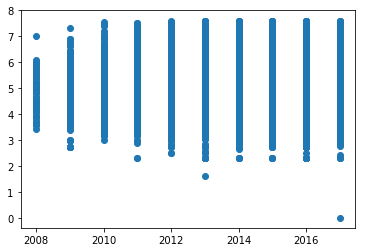

In [854]:
plt.scatter(listings.year_of_listing, listings.log_price)

### Visualization of target variables

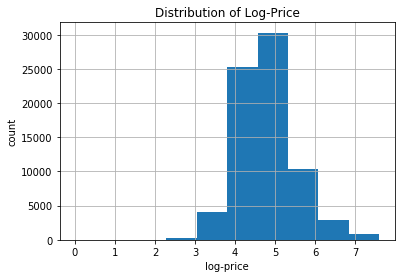

In [855]:
# The Log Price column
plot = listings.log_price.hist()
plt.title('Distribution of Log-Price')
plt.xlabel('log-price')
plt.ylabel('count')
plt.show()

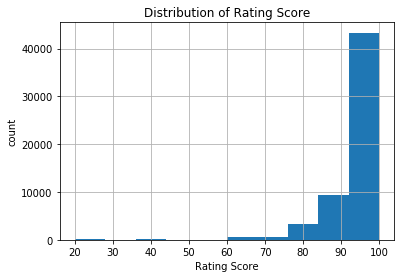

In [856]:
# The review score column
listings.review_scores_rating.hist()
plt.title('Distribution of Rating Score')
plt.xlabel('Rating Score')
plt.ylabel('count')
plt.show()

In [857]:
listings.columns

Index(['id', 'log_price', 'property_type', 'amenities', 'accommodates',
       'bed_type', 'cancellation_policy', 'cleaning_fee',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'latitude', 'longitude', 'name',
       'Neighbourhood', 'number_of_reviews', 'review_scores_rating',
       'thumbnail_url', 'dist_to_attr1', 'dist_to_attr2', 'dist_to_attr3',
       'Entire home/apt', 'Private room', 'Shared room', 'Boston', 'Chicago',
       'DC', 'LA', 'NYC', 'SF', 'year_of_listing', 'month_of_listing',
       'days_since_hosted', 'bedroom_share', 'bathroom_share',
       'description_length', 'sentiment_intensity', 'lda_attractions',
       'lda_transport', 'lda_amenities', 'lda_property_desc',
       'Air conditioning', 'Breakfast', 'Buzzer/wireless intercom', 'Cable TV',
       'Doorman', 'Dryer', 'Elevator', 'Elevator in building',
       'Family/kid friendly', 'Free parking on premises', 'Indoor fireplace',
       

In [871]:
categorical_cols = []
numerical_cols = ['log_price', 'accommodates', 'number_of_reviews', 
                  'review_scores_rating', 'days_since_hosted',
                  'bedroom_share', 'bathroom_share']
text_cols = []


In [872]:
listings.loc[:,numerical_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73923 entries, 0 to 73922
Data columns (total 7 columns):
log_price               73923 non-null float64
accommodates            73923 non-null int64
number_of_reviews       73923 non-null int64
review_scores_rating    57248 non-null float64
days_since_hosted       73923 non-null float64
bedroom_share           73923 non-null float64
bathroom_share          73923 non-null float64
dtypes: float64(5), int64(2)
memory usage: 4.5 MB


### Modelling

In [873]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

In [874]:
listings.columns

Index(['id', 'log_price', 'property_type', 'amenities', 'accommodates',
       'bed_type', 'cancellation_policy', 'cleaning_fee',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'latitude', 'longitude', 'name',
       'Neighbourhood', 'number_of_reviews', 'review_scores_rating',
       'thumbnail_url', 'dist_to_attr1', 'dist_to_attr2', 'dist_to_attr3',
       'Entire home/apt', 'Private room', 'Shared room', 'Boston', 'Chicago',
       'DC', 'LA', 'NYC', 'SF', 'year_of_listing', 'month_of_listing',
       'days_since_hosted', 'bedroom_share', 'bathroom_share',
       'description_length', 'sentiment_intensity', 'lda_attractions',
       'lda_transport', 'lda_amenities', 'lda_property_desc',
       'Air conditioning', 'Breakfast', 'Buzzer/wireless intercom', 'Cable TV',
       'Doorman', 'Dryer', 'Elevator', 'Elevator in building',
       'Family/kid friendly', 'Free parking on premises', 'Indoor fireplace',
       

In [875]:
np.random.seed(2018)
train = np.random.choice([True, False], listings.shape[0], replace=True, p=[0.5, 0.5])
listings_train = listings.iloc[train,:]
listings_test = listings.iloc[~train,:]


In [876]:
train_cols = ['accommodates', 'bedroom_share', 'bathroom_share', 'year_of_listing']
target_col = ['log_price']

x_train = listings_train[train_cols].values
x_test = listings_test[train_cols].values
y_train = listings_train[target_col].values
y_test = listings_test[target_col].values

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(37068, 4) (36855, 4) (37068, 1) (36855, 1)


### Linear Regression Model

In [877]:
# Declare an instance of the Linear Regression model.
lm = LinearRegression()

# Fit the model on to the training data( Train the model ).
lm.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [878]:
# Check the R^2 value of the model.
print("R^2 value using score fn: %.3f" % lm.score(x_test,y_test))

R^2 value using score fn: 0.335


In [879]:
# Use the model to predict values
y_pred = lm.predict(x_test)

In [880]:
# Calculate the Mean Squared Error using the mean_squared_error function.
mean_squared_error(y_test,y_pred)


0.3407720511685944

In [881]:
print(lm.intercept_, lm.coef_)

[69.80430925] [[ 0.17297998 -0.07522346 -0.19066774 -0.03248873]]


In [882]:
y_pred.shape

(36855, 1)

Text(0.5,1,'Residuals for the model')

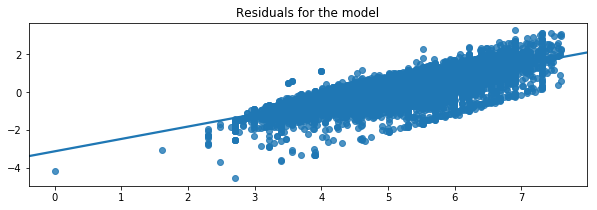

In [883]:
# Plot of Casual and Registered model's residuals:
fig = plt.figure(figsize=(10,3))

sns.regplot(y_test[:,0],y_test[:,0] - y_pred[:,0])
plt.title("Residuals for the model")
